In [1]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

/scratch/user/achadha7/.conda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import IPython
IPython.utils.encoding.getdefaultencoding()

'UTF-8'

In [3]:
import sys
sys.getdefaultencoding()

'utf-8'

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['OMP_NUM_THREADS'] = '4'

In [5]:
# read files
def readInputFiles(train_file_path, test_file_path):
    train = pd.read_csv(train_file_path)
    test = pd.read_csv(test_file_path)
    train = train.sample(frac=1)
    return train, test
    
train, test = readInputFiles('../dataset/train_new.csv', '../dataset/test_new.csv')

In [6]:
EMBEDDING_FILE = '../embeddings/fasttext/crawl-300d-2M.vec'

In [8]:
def add_columns(df):
    df['unclean'] = 0
    df.loc[(df["toxic"] == 1) | (df["severe_toxic"] == 1) | (df["obscene"] == 1)\
           | (df["threat"] == 1) | (df["insult"] == 1) | (df["identity_hate"] == 1),'unclean'] = 1

add_columns(train)
add_columns(test)

In [9]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
list_classes_v2 = ["unclean"]
max_features = 20000
maxlen = 200
embed_size = 300

def preprocess_data():
    
    y = train[list_classes_v2].values
    y_test = test[list_classes_v2].values
    list_sentences_train = train["comment_text"].fillna("CVxTz").values
    list_sentences_test = test["comment_text"].fillna("CVxTz").values
   
    tokenizer = Tokenizer(num_words=max_features)

    tokenizer.fit_on_texts(list(list_sentences_train))
    
    list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
    list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
    
    X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
    X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
    
    return max_features, maxlen, X_train, X_test, y, y_test, tokenizer

In [10]:
max_features, maxlen, X_train, X_test, y, y_test, tokenizer = preprocess_data()

In [ ]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

In [ ]:
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding='utf-8'))

In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


In [5]:
def get_model():
    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [9]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [6]:
def createModel():
    model = get_model()
    batch_size = 32
    epochs=2
    model.fit(X_train, y, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    return model

## Fit model if doesn't exist already 

In [21]:
print("start fitting...")
file_path = "pooledgru_fasttext_model_v3.h5"
if os.path.isfile(file_path):
    print ("Model already exists. Loading from path ", file_path)
    model = load_model(file_path)
else:
    print ("Model doesn't exist already, training model and saving at path ", file_path)
    model = createModel()
    model.save(file_path)

start fitting...
('Model already exists. Loading from path ', 'pooledgru_fasttext_model_v2.h5')


In [15]:
print("start predicting...")
y_pred = model.predict(X_test, batch_size=1024)
print ("done")

start predicting...
done


In [16]:
submission = pd.DataFrame.from_dict({'id': test['id']})
for idx, col in enumerate(list_classes):
    submission[col] = y_pred[:,idx]
submission.to_csv('submission_pooled.csv', index=False)

## Calculate AUC loss

In [17]:
from score import calc_auc_score, calc_log_loss

In [27]:
def get_scores(test, preds, fallback_preds_filename):
    try: 
        true = test
    except NameError:
        true = pd.read_csv('../dataset/test_new.csv')
    try: 
        y_pred = preds
    except NameError:
        pred = pd.read_csv(fallback_preds_filename)
        y_pred = pred[list_classes].values

    y_true = true[list_classes].values

    loss = calc_log_loss(y_true, y_pred)
    auc = calc_auc_score(y_true, y_pred)
    return loss, auc

In [29]:
true = pd.read_csv('./dataset/test_new.csv')
pred = y_pred

loss_, aucs = get_scores(true, pred, fallback_preds_filename=None)

In [31]:
print ("Log loss = ", loss_)
print ("AUC Score = ", aucs)

Log loss =  0.041929289638716
AUC Score =  0.9878130862611308


## Demo

In [77]:
zgg = tokenizer.texts_to_sequences(["Not the brightest crayon in the box now, are we?"])
aaa = sequence.pad_sequences(zgg, maxlen=200)
np.set_printoptions(suppress=True)
model.predict(aaa)

array([[0.06863956, 0.01733674, 0.03352913, 0.00464096, 0.03596547,
        0.01597567]], dtype=float32)

In [79]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200, 160)     182880      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

In [13]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [9]:
model = get_model()

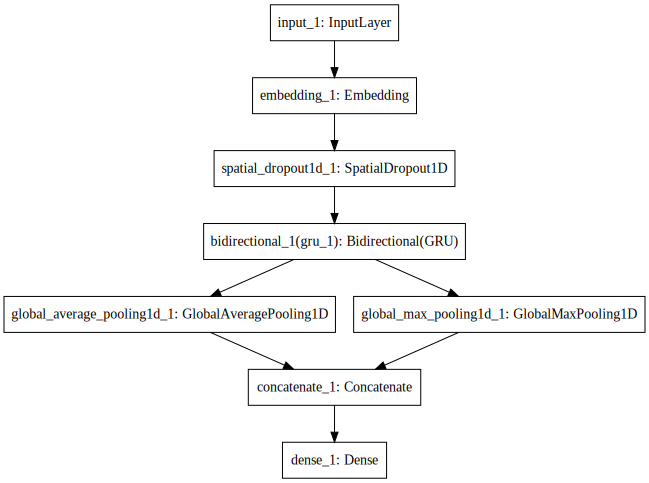